ArXiv Articles: Computation and Language

In [1]:
# pip install datasets==2.14.6 fsspec==2023.10.0

In [2]:
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Titles', 'Abstracts', 'Years', 'Categories'],
        num_rows: 44949
    })
})

In [4]:
dataset=dataset["train"]

In [5]:
dataset

Dataset({
    features: ['Titles', 'Abstracts', 'Years', 'Categories'],
    num_rows: 44949
})

In [6]:
abstract=dataset["Abstracts"]
titles=dataset["Titles"]

A common pipeline for text clustering

1. Embedding Documents

In [7]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings=embedding_model.encode(abstract,show_progrss_bar=True)

In [8]:
embeddings.shape

(44949, 384)

2. Reducing the dimensionality of embeddings

In [9]:
from umap import UMAP

umap_model=UMAP(n_components=5,min_dist=0.0,metric="cosine",random_state=42)
reduce_embeddings=umap_model.fit_transform(embeddings)

3. Cluster the reduced embeddings

In [10]:
from hdbscan import HDBSCAN

hdbscan_model=HDBSCAN(min_cluster_size=50,metric="euclidean",cluster_selection_method="eom",prediction_data=True).fit(reduce_embeddings)
clusters=hdbscan_model.labels_

len(set(clusters))

155

Inspecting the clusters

Manually inspect the first three documents in cluster 0:

In [11]:
import numpy as np
cluster=0

for index in np.where(clusters==cluster)[0][:3]:
  print(abstract[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



Next, we reduce our embeddings to 2-D so that we can plot them and get a rough understandings of the generated clusters

In [12]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

Static PLot

(np.float64(-8.334335255622864),
 np.float64(11.817492890357972),
 np.float64(-5.973596382141113),
 np.float64(11.185701179504395))

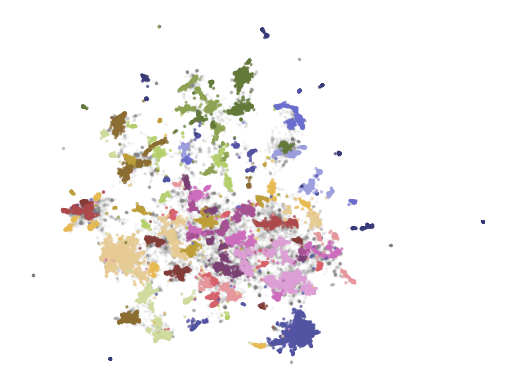

In [13]:
import matplotlib.pyplot as plt

plt.scatter(outliers_df.x,outliers_df.y,alpha=0.05,s=2,c="grey")
plt.scatter(
    clusters_df.x,
    clusters_df.y,
    alpha=0.6,
    c=clusters_df.cluster.astype(int),
    cmap="tab20b",
    s=2,
)

plt.axis('off')

From Text Clustering to Topic Modelling

BERTopic: A Modular Topic Modeling Framework

In [16]:
from bertopic import BERTopic

topic_model=BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts,embeddings)

2025-06-29 16:06:36,677 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-29 16:07:35,567 - BERTopic - Dimensionality - Completed ✓
2025-06-29 16:07:35,569 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-29 16:07:38,615 - BERTopic - Cluster - Completed ✓
2025-06-29 16:07:38,644 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-29 16:07:42,517 - BERTopic - Representation - Completed ✓


In [ ]:
# pip install bertopic

In [17]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14210                               -1_of_the_and_to   
1        0   2316                   0_speech_asr_recognition_end   
2        1   2183                 1_question_qa_questions_answer   
3        2    941                 2_translation_nmt_machine_bleu   
4        3    880  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
150    149     54          149_sentence_embeddings_sts_embedding   
151    150     54            150_gans_gan_adversarial_generation   
152    151     54         151_coherence_discourse_paragraph_text   
153    152     53                   152_chatgpt_its_openai_tasks   
154    153     52    153_opinion_reviews_summaries_summarization   

                                        Representation  \
0    [of, the, and, to, in, we, language, for, that...   
1    [speech, asr, recognition, end, acoustic, spea...   
2    [question, qa, questions, answer, answering, a...   
3    [translation, nmt, machine, bleu, neural, engl...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
150  [sentence, embeddings, sts, embedding, similar...   
151  [gans, gan, adversarial, generation, generativ...   
152  [coherence, discourse, paragraph, text, cohesi...   
153  [chatgpt, its, openai, tasks, has, ai, capabil...   
154  [opinion, reviews, summaries, summarization, r...   

                                   Representative_Docs  
0    [  GPT-$3$ has attracted lots of attention due...  
1    [  The speech chain mechanism integrates autom...  
2    [  Text-based Question Generation (QG) aims at...  
3    [  Recently, the development of neural machine...  
4    [  Sentence summarization shortens given texts...  
..                                                 ...  
150  [  Sentence representation at the semantic lev...  
151  [  Text generation is of particular interest i...  
152  [  While there has been significant progress t...  
153  [  Over the last few years, large language mod...  
154  [  When faced with a large number of product r...  

[155 rows x 5 columns]

In [18]:
topic_model.get_topic(0)

[('speech', np.float64(0.028208883288593535)),
 ('asr', np.float64(0.018842312810416793)),
 ('recognition', np.float64(0.01351959051292077)),
 ('end', np.float64(0.009745990895354896)),
 ('acoustic', np.float64(0.009384710004108402)),
 ('speaker', np.float64(0.006877359138616964)),
 ('audio', np.float64(0.006785262733110495)),
 ('the', np.float64(0.006370412745274845)),
 ('error', np.float64(0.00634287314665723)),
 ('automatic', np.float64(0.0063065026437668335))]

In [19]:
topic_model.find_topics("deep learning")

([17, -1, 22, 40, 9],
 [np.float32(0.8835353),
  np.float32(0.8823885),
  np.float32(0.8821352),
  np.float32(0.88074785),
  np.float32(0.8793167)])

In [20]:
topic_model.get_topic(24)

[('topic', np.float64(0.06811153301756999)),
 ('topics', np.float64(0.035746717561104396)),
 ('lda', np.float64(0.016020062969070364)),
 ('latent', np.float64(0.013574936227317968)),
 ('documents', np.float64(0.013201698266173009)),
 ('document', np.float64(0.012912590658853182)),
 ('modeling', np.float64(0.012084716289729468)),
 ('dirichlet', np.float64(0.01010281253111858)),
 ('word', np.float64(0.008653858081603273)),
 ('allocation', np.float64(0.007950503995528465))]

In [21]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

24

Visualization

In [30]:
import plotly.express as px

fig = px.scatter(
    df,
    x="x",
    y="y",
    color="cluster",
    hover_data=["title", "cluster"],
    title="Document Clusters",
    width=1200,
    height=800
)

fig.update_layout(font=dict(size=16))
fig.show()